# Natural language Processing (NLP)

## Задачи NLP:
##### 1) Классификация текстов(автор, жанр и т.д.)
##### 2) Анализ эмоциональной составляющей текста
##### 3) Машинный перевод
##### 4) Генерация текстов
##### 5) Поиск ответа в заданном тексте на поставленный вопрос


## Варианты представлений текста в компьютере

### - One-hot encoding
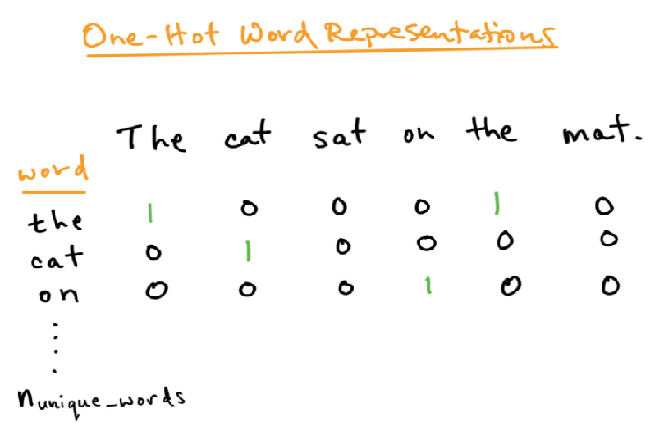
#### Недостатки:
##### a) Векторы не содержат никакого смысла
##### b) Векторы слов нельзя сравнить между собой

## - Context embeddings:
#### vocabulary[cat] = [5 # clew, 7 # mouse, 2 # sheep ... ]
#### vocabulary[dog] = [0 # clew, 1 # mouse, 9 # sheep ... ]

### Недостатки:
##### редкие слова
##### Необходимо большое количество времени, чтобы всё посчитать
##### При добавлении нового текста необходимо добавлять новые значние в словарь

## Word2Vec
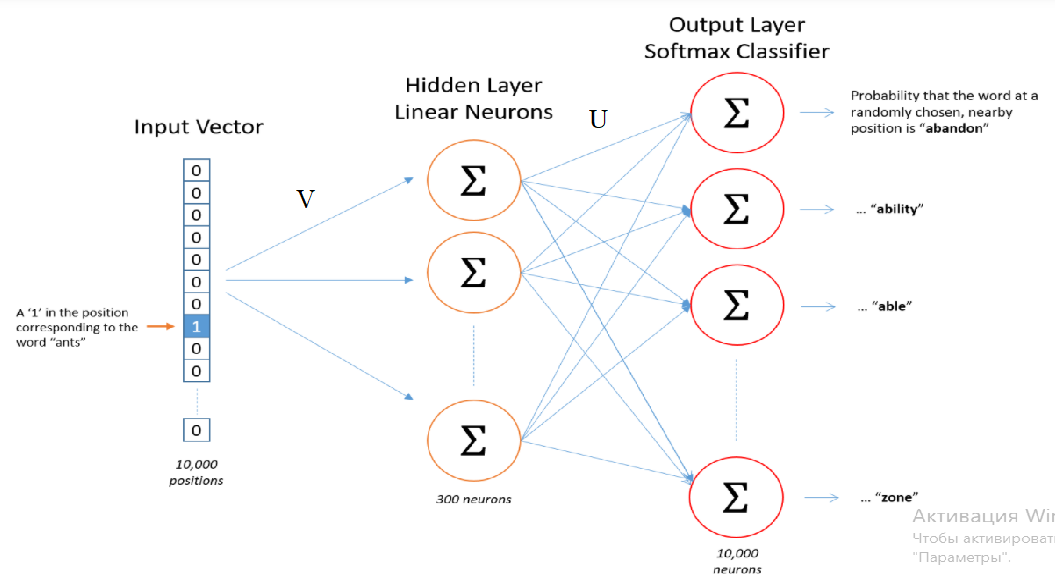
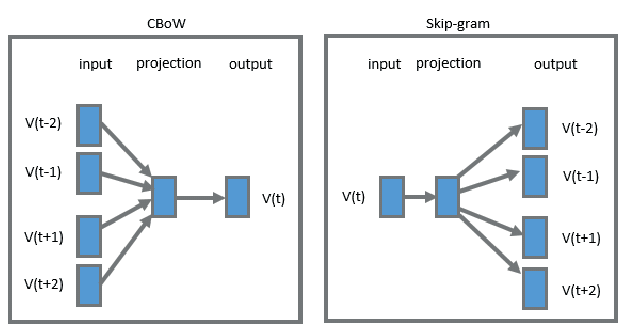
##  $$ P =\frac {e^{U^T_0V_c}}{\sum_{\omega \epsilon V} e^{U^T_\omega V_c}} $$ 
## $$J(\theta) =  -\frac{1}{T} \sum_{t=1}^T \sum_{-m \leq j \leq m;  j\neq0}logP(w_{t+j}|w_t;\theta)$$


# Glove
## $$J(\theta) =  \frac{1}{2} \sum_{i,j=1}^W f(P_{ij})(U^T_iV_j-logP_{ij})^2$$
###  $f(P_{ij})$ - функция, которая учитывает редкие слова

In [1]:
!curl -O http://mattmahoney.net/dc/text8.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 29.8M    0   97k    0     0    97k      0  0:05:12  0:00:01  0:05:11 77326
  1 29.8M    1  403k    0     0   201k      0  0:02:31  0:00:02  0:02:29  184k
  2 29.8M    2  711k    0     0   237k      0  0:02:09  0:00:03  0:02:06  223k
  3 29.8M    3 1009k    0     0   252k      0  0:02:01  0:00:04  0:01:57  241k
  4 29.8M    4 1293k    0     0   258k      0  0:01:58  0:00:05  0:01:53  263k
  5 29.8M    5 1597k    0     0   266k      0  0:01:54  0:00:06  0:01:48  306k
  6 29.8M    6 1880k    0     0   268k      0  0:01:53  0:00:07  0:01:46  295k
  7 29.8M    7 2181k    0     0   272k      0  0:01:52  0:00:08  0:01:44  293k
  8 29.8M    8 2488k    0     0   276k      0  0:01

In [10]:
import re
from collections import Counter
from tqdm.notebook import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from catalyst import dl

In [42]:
class W2VCorpus:
    def __init__(
        self, path, voc_max_size: int = 40000, min_word_freq: int = 20, max_corp_size=5e6
    ):
        corpus = []
        sentences = []
        with open(path, "r") as inp:
            for line in inp:
                corpus.append(line.split())
                sentences.append(line)
        corpus = np.array(corpus)
        self.corpus = corpus
        most_freq_word = \
            Counter(' '.join(sentences).split()).most_common(voc_max_size)
        most_freq_word = np.array(most_freq_word)
        most_freq_word = \
            most_freq_word[most_freq_word[:, 1].astype(int) > min_word_freq]
        
        print('Vocabulary size is:' + str(len(most_freq_word)))
        self.vocabulary = set(most_freq_word[:, 0])
        self.vocabulary.update(["<PAD>"])
        self.vocabulary.update(["<UNK>"])
        self.word_freq = most_freq_word
        self.idx_to_word = dict(list(enumerate(self.vocabulary)))
        self.word_to_idx = \
            dict([(i[1], i[0]) for i in enumerate(self.vocabulary)])
        self.W = None
        self.P = None
        self.positive_pairs = None
        
    def make_positive_dataset(self, window_size=2):
        """take corpus and make positive examples for skipgram or CBOW
           like: [1234], [[3333, 1111, 2222, 4444]]"""
        if not self.W is None:
            return self.W, self.P
        W = []
        P = []
        pbar = tqdm(self.corpus)
        pbar.set_description('Creating context dataset')
        for message in pbar:

            if len(self.corpus) == 1:
                iter_ = tqdm(enumerate(message), total=len(message))
            else:
                iter_ = enumerate(message)
            
            for idx, word in iter_:
                if word not in self.vocabulary:
                    word = "<UNK>"
                start_idx = max(0, idx - window_size)
                end_idx = min(len(message), idx+window_size+1)
                pos_in_window = window_size
                if idx - window_size < 0:  # start of the sentence
                    pos_in_window += idx - window_size
                    
                co_words = message[start_idx:end_idx]  # cuts window from sentence
                co_words = np.delete(co_words, pos_in_window)  # deletes central word from context
                filtered_co_words = []
                
                for co_word in co_words:
                    if co_word in self.vocabulary:
                        filtered_co_words.append(co_word)
                    else:
                        filtered_co_words.append("<UNK>")
                while len(filtered_co_words) < 2*window_size:
                    filtered_co_words.append("<PAD>")
                W.append(self.word_to_idx[word])
                co_word_idx = [self.word_to_idx[co_word] for co_word in filtered_co_words]
                P.append(co_word_idx)
        self.W = W
        self.P = P
        del self.corpus
        return W, P
    
    def make_positive_pairs(self):
        """[1234], [[3333, 1111, 2222, 4444]] ->
            [1234, 3333],
            [1234, 1111],
            ....
            [9999, 1982],

        """
        if not self.positive_pairs is None:
            return self.positive_pairs
        if self.W is None:
            self.make_positive_dataset()
        pairs = []
        pbar = tqdm(zip(self.W, self.P), total=len(self.W))
        pbar.set_description('Creating positive pairs')
        for w, p in pbar:
            for cur_p in p:
                if cur_p != self.word_to_idx["<PAD>"]:  # pad
                    pairs.append([w, cur_p])
        self.positive_pairs = pairs
        return pairs


In [43]:
corp = W2VCorpus("text8")

pairs = corp.make_positive_pairs()

Vocabulary size is:30964


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17005207 [00:00<?, ?it/s]

  0%|          | 0/17005207 [00:00<?, ?it/s]

In [50]:
pairs[0:10]

[[25265, 18627],
 [25265, 22253],
 [18627, 25265],
 [18627, 22253],
 [18627, 21072],
 [22253, 25265],
 [22253, 18627],
 [22253, 21072],
 [22253, 8066],
 [21072, 18627]]

In [3]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

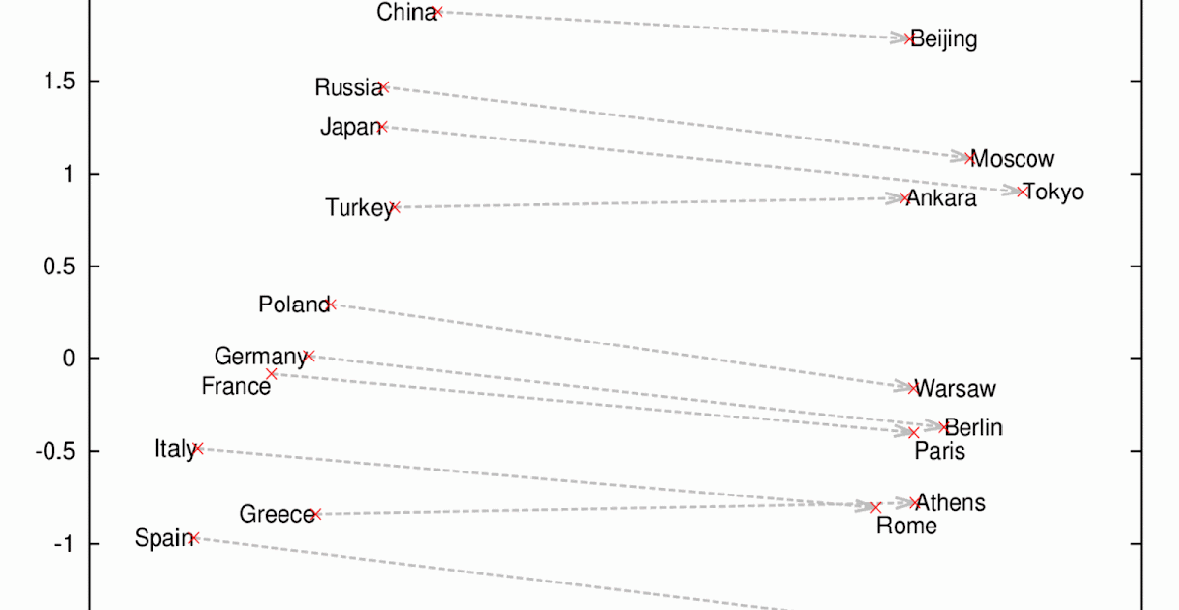

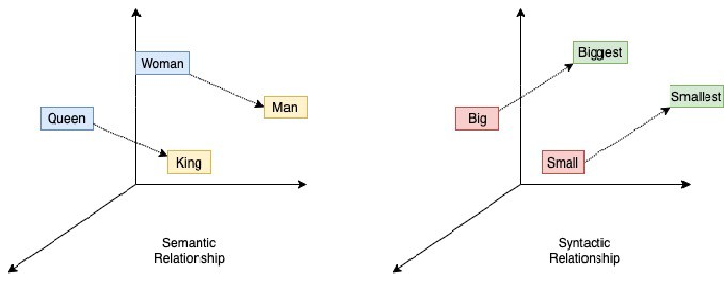

In [4]:
model.most_similar(positive=['director', 'woman'], negative=['man'], topn=5)

[('chairwoman', 0.6557496190071106),
 ('coordinator', 0.6399919390678406),
 ('vice_president', 0.6261624097824097),
 ('Executive_Director', 0.6241751313209534),
 ('Director', 0.6134443283081055)]

In [10]:
model.similarity("Oscar", "DiCaprio")

0.3627493

In [11]:
model.similarity("Oscar", "Disney")

0.16863005

# $$BERT$$
## 2 стадии:
### -Pre-training: учим модель понимать язык:
##### 1) Общее понимание языка. Реазлизована идея Masked  Language Model - 15 % слов предложения закрывается токеном MASK
##### 2) Нахождение зависимости между 2-мя предложениями. Реализована идея Next Sentence Prediction - модель определяет наличие последовательности 2-ух предложений
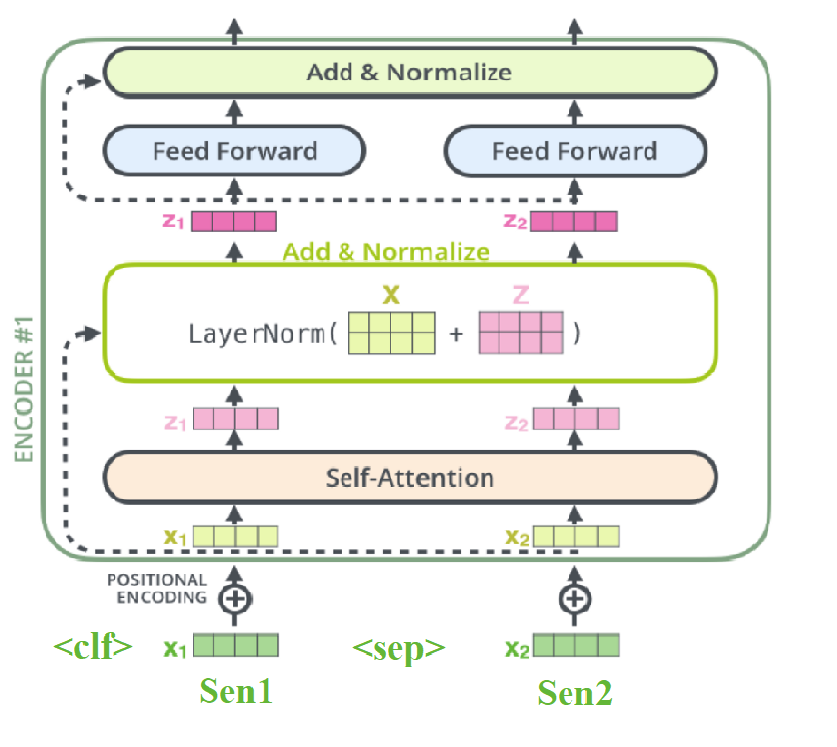
### -Fine-tuning: затачиваем модель под конкретную задачу - классификация текстов, поиск ответов и т.д.
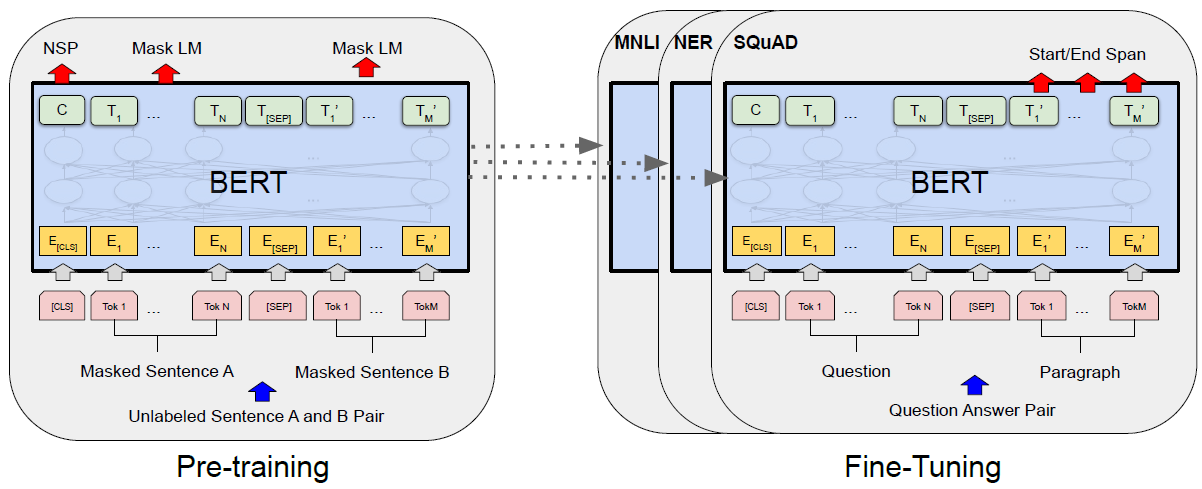

In [4]:
!pip install transformers

  Using cached transformers-4.9.2-py3-none-any.whl (2.6 MB)


In [15]:
!pip install beautifulsoup4

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [6]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [7]:
tokens = tokenizer.encode('It was good but couldve been better. Great!', return_tensors='pt')
result = model(tokens)

In [8]:
result.logits

tensor([[-2.9522, -1.4049,  1.4226,  2.1058,  0.6519]],
       grad_fn=<AddmmBackward>)

In [14]:
int(torch.argmax(result.logits))+1

3

In [17]:
r = requests.get('https://www.yelp.com/biz/mejico-sydney-2')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class': regex})
reviews = [result.text for result in results]

In [23]:
results[0].text

'The food is fresh and tasty. \xa0The scallop ceviche started the lunch. The scallops were tender with a great acidity and use of mango and peppers. The steak was tender and I got the hint of tequila in the sauce. I enjoyed a watermelon salad that complimented the the steak. The portions are good, but a stretch if you are sharing. My only down point is the service. They really only showed up to present my next plate and never checked to see if I wanted another drink (which I did).Enjoyed the food.'

In [30]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [32]:
df

,review
0,The food is fresh and tasty. The scallop cevi...
1,Don't come here expecting legit Mexican food b...
2,Out of all the restaurants that I tried in Syd...
3,Ordered feed me for $59 along with that.. Food...
4,I was pleasantly surprised at what a great job...
5,Really nice (upmarket) Mexican restaurant. Goo...
6,We came here on a Thursday night @ 5pm and by ...
7,"The best tasting cauliflower taco, mushroom ce..."
8,Why is it that all Mexican food outside of Mex...
9,Have been here twice and have absolutely loved...


In [35]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1
    

In [36]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [38]:
df

,review,sentiment
0,The food is fresh and tasty. The scallop cevi...,4
1,Don't come here expecting legit Mexican food b...,3
2,Out of all the restaurants that I tried in Syd...,5
3,Ordered feed me for $59 along with that.. Food...,2
4,I was pleasantly surprised at what a great job...,5
5,Really nice (upmarket) Mexican restaurant. Goo...,4
6,We came here on a Thursday night @ 5pm and by ...,4
7,"The best tasting cauliflower taco, mushroom ce...",5
8,Why is it that all Mexican food outside of Mex...,3
9,Have been here twice and have absolutely loved...,5


In [41]:
df['review'].iloc[3]

'Ordered feed me for $59 along with that.. Food was good quality but the service was tragic and wait was poorly managed. Personally if your with a group and looking for light finger food size portion then this would maybe be suitable for you,'